In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geographiclib.geodesic import Geodesic
import math
from cmdstanpy import CmdStanModel, set_cmdstan_path
import os
import arviz as az

CMDSTAN_PATH = "/home/klemen/micromamba/envs/gps/bin/cmdstan"
KNOWN_POINTS_CSV = 'NM/known_points.csv'
REF_POINTS_CSV = 'NM/points.csv'
STAN_MODEL_PATH = 'newmodel.stan'
set_cmdstan_path(CMDSTAN_PATH)

# Quick sanity check
assert KNOWN_POINTS_CSV != REF_POINTS_CSV
assert KNOWN_POINTS_CSV.split('/')[0] == REF_POINTS_CSV.split('/')[0] # Ensure the data is from the same area

def read_known_points(known_csv):
    df = pd.read_csv(known_csv)
    print(f"Read {len(df)} known points from {known_csv}")
    assert len(df) == np.unique(df['name']).shape[0]
    return df

# Our goal is to assist the investigation by providing a relative quantification of whether the the device was at the proposed points P1, P2... when it took the evidence E due to GPS error.
known_points_df = read_known_points(KNOWN_POINTS_CSV)
known_points_df

Read 4 known points from NM/known_points.csv


/home/klemen/micromamba/envs/gps/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,name,lat,lng
0,P1,45.828472,15.220485
1,P2,45.828432,15.220255
2,P3,45.828386,15.220487
3,E,45.828369,15.220408


In [2]:
def lat_lng2dist_ang(center_point_lat_lng, target_point_lat_lng):
    # center_point_lat_lng = [lat, lng] this is one of the known proposal points (not the evidence point)
    # target_point_lat_lng = [lat, lng] this is one of the measured points for the proposal, can also be the evidence point
    # computes distance (in meters) between two points and azimuth (angle from north in radians) of the line using WGS84 ellipsoid, line spins around center_point_lat_lng
    # computes angle (in radians and degrees) between two points
    results = Geodesic.WGS84.Inverse(center_point_lat_lng[0], center_point_lat_lng[1], target_point_lat_lng[0], target_point_lat_lng[1])
    distance = results['s12']
    angle_deg = results['azi1']
    angle = math.radians(angle_deg)
    return distance, angle, angle_deg

def prepare_measurements_for_proposal(ref_csv, proposal_name, known_points_df):
    proposal_lat_lng = known_points_df[known_points_df['name'] == proposal_name][['lat', 'lng']].values[0].tolist()
    print(f"Proposal {proposal_name} lat, lng: {proposal_lat_lng}")
    df = pd.read_csv(ref_csv)
    needed_columns = ['datetime', 'measured_from', 'lat', 'lng', 'precise']
    df = df[needed_columns]
    df = df[df['measured_from'] == proposal_name]
    df = df[df['precise'] == 'on']
    df = df.drop(columns=['precise'])
    df = df.sort_values(by='datetime', ascending=True, ignore_index=True)
    # flag indicating if two consecutive (by datetime) measurements  are the same (lat, lng)
    df['same_as_prev'] = df[['lat', 'lng']].duplicated(keep='first')
    num_rows = df.shape[0]
    num_duplicates = df['same_as_prev'].sum()
    print(f"Number of measurements for proposal {proposal_name}: {num_rows}")
    print(f"Number of duplicate consecutive measurements: {num_duplicates} ({num_duplicates/num_rows*100:.2f}%)")
    # remove duplicate consecutive measurements
    df = df[df['same_as_prev'] == False]
    df = df.drop(columns=['same_as_prev'])
    df = df.reset_index(drop=True)
    
    df["dist"] = df.apply(lambda x: lat_lng2dist_ang(proposal_lat_lng, [x["lat"], x["lng"]])[0], axis=1)
    df["angle"] = df.apply(lambda x: lat_lng2dist_ang(proposal_lat_lng, [x["lat"], x["lng"]])[1], axis=1)
    df["angle_deg"] = df.apply(lambda x: lat_lng2dist_ang(proposal_lat_lng, [x["lat"], x["lng"]])[2], axis=1)

    print(f"Clean measurements for proposal {proposal_name}: {df.shape[0]}")
    display(df)
    display(df.describe())
    return df

p1_measurements = prepare_measurements_for_proposal(REF_POINTS_CSV, 'P1', known_points_df)
p2_measurements = prepare_measurements_for_proposal(REF_POINTS_CSV, 'P2', known_points_df)
p3_measurements = prepare_measurements_for_proposal(REF_POINTS_CSV, 'P3', known_points_df)
E_wrt_P1 = lat_lng2dist_ang(known_points_df[known_points_df['name'] == 'P1'][['lat', 'lng']].values[0].tolist(), known_points_df[known_points_df['name'] == 'E'][['lat', 'lng']].values[0].tolist())
E_wrt_P1 = [E_wrt_P1[0], E_wrt_P1[1]]
E_wrt_P2 = lat_lng2dist_ang(known_points_df[known_points_df['name'] == 'P2'][['lat', 'lng']].values[0].tolist(), known_points_df[known_points_df['name'] == 'E'][['lat', 'lng']].values[0].tolist())
E_wrt_P2 = [E_wrt_P2[0], E_wrt_P2[1]]
E_wrt_P3 = lat_lng2dist_ang(known_points_df[known_points_df['name'] == 'P3'][['lat', 'lng']].values[0].tolist(), known_points_df[known_points_df['name'] == 'E'][['lat', 'lng']].values[0].tolist())
E_wrt_P3 = [E_wrt_P3[0], E_wrt_P3[1]]
print(f"E_wrt_P1: {E_wrt_P1}")
print(f"E_wrt_P2: {E_wrt_P2}")
print(f"E_wrt_P3: {E_wrt_P3}")

Proposal P1 lat, lng: [45.82847186111111, 15.22048538888889]
Number of measurements for proposal P1: 100
Number of duplicate consecutive measurements: 75 (75.00%)
Clean measurements for proposal P1: 25


,datetime,measured_from,lat,lng,dist,angle,angle_deg
0,2024:04:27 13:32:27,P1,45.828472,15.220483,0.164687,-1.324602,-75.894089
1,2024:04:27 13:32:28,P1,45.828475,15.220481,0.512605,-0.822210,-47.109157
2,2024:04:27 13:32:28,P1,45.828475,15.220475,0.879406,-1.162852,-66.626492
3,2024:04:27 13:32:31,P1,45.828481,15.220478,1.132972,-0.549183,-31.465878
4,2024:04:27 13:32:34,P1,45.828472,15.220486,0.068994,0.949931,54.427021
5,2024:04:27 13:32:38,P1,45.828475,15.220489,0.442356,0.662125,37.936951
6,2024:04:27 13:32:39,P1,45.828475,15.220494,0.785381,1.110494,63.626633
7,2024:04:27 13:32:40,P1,45.828475,15.220492,0.599721,0.949931,54.427019
8,2024:04:27 13:32:44,P1,45.828472,15.220489,0.274904,1.424270,81.604641
9,2024:04:27 13:32:46,P1,45.828472,15.220492,0.489446,1.488700,85.296208


,lat,lng,dist,angle,angle_deg
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,45.828471,15.220484,0.593417,-0.020074,-1.150145
std,0.000004,0.000006,0.273815,1.933889,110.803656
min,45.828464,15.220475,0.068994,-2.963255,-169.781990
25%,45.828469,15.220481,0.382245,-1.503033,-86.117443
50%,45.828472,15.220483,0.592761,-0.549183,-31.465878
75%,45.828475,15.220489,0.808238,1.488700,85.296208
max,45.828481,15.220494,1.132972,3.078345,176.376177


Proposal P2 lat, lng: [45.82843192982457, 15.220255146198827]
Number of measurements for proposal P2: 95
Number of duplicate consecutive measurements: 70 (73.68%)
Clean measurements for proposal P2: 25


,datetime,measured_from,lat,lng,dist,angle,angle_deg
0,2024:04:27 13:34:30,P2,45.828456,15.220189,5.779370,-1.099135,-62.975798
1,2024:04:27 13:34:32,P2,45.828431,15.220219,2.778313,-1.625802,-93.151607
2,2024:04:27 13:34:32,P2,45.828433,15.220214,3.209584,-1.522173,-87.214110
3,2024:04:27 13:34:34,P2,45.828425,15.220222,2.671706,-1.863240,-106.755814
4,2024:04:27 13:34:35,P2,45.828425,15.220225,2.465816,-1.888478,-108.201837
5,2024:04:27 13:34:38,P2,45.828425,15.220233,1.861716,-1.997336,-114.438949
6,2024:04:27 13:34:39,P2,45.828425,15.220239,1.479533,-2.118343,-121.372098
7,2024:04:27 13:34:40,P2,45.828431,15.220242,1.058471,-1.715611,-98.297279
8,2024:04:27 13:34:42,P2,45.828431,15.220244,0.845464,-1.752460,-100.408589
9,2024:04:27 13:34:51,P2,45.828431,15.220247,0.634376,-1.813969,-103.932782


,lat,lng,dist,angle,angle_deg
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,45.828433,15.220259,2.123139,0.035224,2.018196
std,0.000007,0.000029,1.064328,1.594077,91.333873
min,45.828425,15.220189,0.429223,-2.118343,-121.372098
25%,45.828431,15.220239,1.550987,-1.715611,-98.297279
50%,45.828431,15.220269,2.195527,0.798518,45.751725
75%,45.828433,15.220283,2.626333,1.511368,86.595015
max,45.828456,15.220294,5.779370,1.657440,94.964293


Proposal P3 lat, lng: [45.82838566784871, 15.220487234042553]
Number of measurements for proposal P3: 94
Number of duplicate consecutive measurements: 80 (85.11%)
Clean measurements for proposal P3: 14


,datetime,measured_from,lat,lng,dist,angle,angle_deg
0,2024:04:27 13:36:33,P3,45.828431,15.220281,16.816560,-1.269578,-72.741478
1,2024:04:27 13:36:34,P3,45.828431,15.220283,16.610562,-1.265723,-72.520595
2,2024:04:27 13:36:34,P3,45.828425,15.220286,16.227686,-1.298028,-74.371545
3,2024:04:27 13:36:35,P3,45.828425,15.220289,16.019931,-1.294399,-74.163582
4,2024:04:27 13:36:36,P3,45.828422,15.220297,15.313207,-1.302256,-74.613793
5,2024:04:27 13:36:37,P3,45.828422,15.220300,15.105212,-1.298465,-74.396572
6,2024:04:27 13:36:38,P3,45.828419,15.220308,14.399037,-1.307021,-74.886805
7,2024:04:27 13:36:39,P3,45.828414,15.220317,13.619623,-1.338401,-76.684720
8,2024:04:27 13:36:40,P3,45.828411,15.220325,12.919290,-1.350114,-77.355808
9,2024:04:27 13:36:41,P3,45.828408,15.220336,12.009810,-1.359462,-77.891440


,lat,lng,dist,angle,angle_deg
count,14.000000,14.000000,14.000000,14.000000,14.000000
mean,45.828411,15.220353,13.525508,-0.876870,-50.240932
std,0.000021,0.000110,2.661178,1.132267,64.874118
min,45.828367,15.220281,9.433322,-1.397740,-80.084621
25%,45.828404,15.220291,11.285619,-1.347185,-77.188036
50%,45.828417,15.220313,14.009330,-1.300361,-74.505182
75%,45.828424,15.220344,15.843250,-1.275783,-73.097004
max,45.828431,15.220608,16.816560,1.796590,102.937050


E_wrt_P1: [12.86199270467897, -2.657380149027305]
E_wrt_P2: [13.78101524512164, 2.0989763923570286]
E_wrt_P3: [6.390458846451682, -1.8568515309230709]


In [3]:
# visualize points on the map TODO
# fig, ax = plt.subplots()
# sns.scatterplot(data=proposal_ref_points_df, x='lng', y='lat', hue='ref_point')
# sns.scatterplot(data=known_points_df, x='lng', y='lat', hue='name', marker='X', s=100)

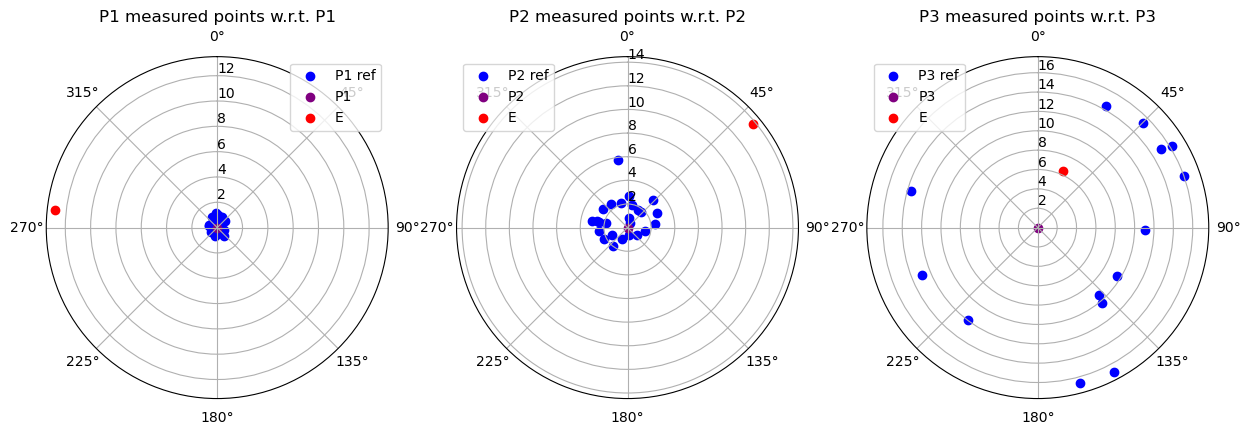

In [4]:
def visualize_polar(proposal_measurements, ax, known_points_df):
    # meters and degrees
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)
    ax.set_title(f"{proposal_measurements['measured_from'][0]} measured points w.r.t. {proposal_measurements['measured_from'][0]}")
    ax.scatter(proposal_measurements["angle_deg"], proposal_measurements["dist"], label=f"{proposal_measurements['measured_from'][0]} ref", color="blue")
    ax.scatter(0, 0, label=proposal_measurements['measured_from'][0], color="purple")
    ax.set_rmax(max(proposal_measurements["dist"]))
    # E lat lng to float
    E_lat_lng = known_points_df[known_points_df['name'] == 'E'][['lat', 'lng']].values[0].tolist()
    P_lat_lng = known_points_df[known_points_df['name'] == proposal_measurements['measured_from'][0]][['lat', 'lng']].values[0].tolist()
    E_dist, _, E_angle_deg = lat_lng2dist_ang(P_lat_lng, E_lat_lng)
    ax.scatter(E_angle_deg, E_dist, label='E', color='red')
    ax.legend()
    return ax

fig, ax = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(15,7))
for ax1, proposal_measurements in zip(ax.flatten(), [p1_measurements, p2_measurements, p3_measurements]):
    visualize_polar(proposal_measurements, ax1, known_points_df)
plt.show()


Here we empirically confirm that the GPS error is very dependent on the (lat, lng) location too.

In [5]:
stan_data = {
    "N_A": p2_measurements.shape[0],
    "N_B": p3_measurements.shape[0],
    "A": p2_measurements.loc[:, ["dist", "angle"]].values,
    "B": p3_measurements.loc[:, ["dist", "angle"]].values,
    "E_A": E_wrt_P2,
    "E_B": E_wrt_P3,
}
stan_data

{'N_A': 25,
 'N_B': 14,
 'A': array([[ 5.77937025, -1.09913503],
        [ 2.77831304, -1.62580224],
        [ 3.20958398, -1.52217337],
        [ 2.67170634, -1.86324044],
        [ 2.46581579, -1.88847831],
        [ 1.86171646, -1.99733645],
        [ 1.47953284, -2.11834273],
        [ 1.05847102, -1.71561117],
        [ 0.84546432, -1.75246047],
        [ 0.63437583, -1.81396925],
        [ 0.42922325, -1.19883793],
        [ 1.0294496 ,  0.72067773],
        [ 1.55098672,  0.79851823],
        [ 1.71223426,  0.886591  ],
        [ 2.19575554,  1.49969139],
        [ 2.41089079,  1.63419576],
        [ 2.62652362,  1.51136813],
        [ 3.05738488,  1.62077697],
        [ 2.62633267,  1.62898884],
        [ 2.1955271 ,  1.64042439],
        [ 1.98026711,  1.64800751],
        [ 1.76514876,  1.65743958],
        [ 1.98052039,  1.49194876],
        [ 2.32277574,  1.23131208],
        [ 2.41109881,  1.5060513 ]]),
 'B': array([[16.81656044, -1.26957829],
        [16.6105618 , -1.265

In [6]:
stan_model = CmdStanModel(stan_file=STAN_MODEL_PATH)
fit = stan_model.sample(data=stan_data,
                        chains=4,
                        iter_warmup=1000,
                        iter_sampling=4000,
                        seed=1,
                        adapt_delta=0.96,
                        parallel_chains=os.cpu_count())
fit.summary()
print(fit.diagnose())

04:02:44 - cmdstanpy - INFO - compiling stan file /home/klemen/programming/gps_evaluation/newmodel.stan to exe file /home/klemen/programming/gps_evaluation/newmodel
04:03:16 - cmdstanpy - INFO - compiled model executable: /home/klemen/programming/gps_evaluation/newmodel
04:03:16 - cmdstanpy - INFO - Requested 8 parallel_chains but only 4 required, will run all chains in parallel.
04:03:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Iteration:    1 / 5000 [  0%]  (Warmup)
chain 1 |▌         | 00:00 Iteration:  100 / 5000 [  2%]  (Warmup)


chain 1 |▊         | 00:00 Iteration:  200 / 5000 [  4%]  (Warmup)


chain 1 |▉         | 00:00 Iteration:  300 / 5000 [  6%]  (Warmup)

chain 1 |█▏        | 00:00 Iteration:  400 / 5000 [  8%]  (Warmup)


chain 1 |█▎        | 00:01 Iteration:  500 / 5000 [ 10%]  (Warmup)


chain 1 |█▌        | 00:01 Iteration:  600 / 5000 [ 12%]  (Warmup)


chain 1 |█▋        | 00:01 Iteration:  700 


04:03:22 - cmdstanpy - INFO - CmdStan done processing.



Processing csv files: /tmp/tmp42gsw7hk/newmodel98vd6zmd/newmodel-20240731040316_1.csv, /tmp/tmp42gsw7hk/newmodel98vd6zmd/newmodel-20240731040316_2.csv, /tmp/tmp42gsw7hk/newmodel98vd6zmd/newmodel-20240731040316_3.csv, /tmp/tmp42gsw7hk/newmodel98vd6zmd/newmodel-20240731040316_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



array([[<Axes: title={'center': 'L_A\n0, 0'}>,
        <Axes: title={'center': 'L_A\n0, 0'}>],
       [<Axes: title={'center': 'L_A\n0, 1'}>,
        <Axes: title={'center': 'L_A\n0, 1'}>],
       [<Axes: title={'center': 'L_A\n1, 0'}>,
        <Axes: title={'center': 'L_A\n1, 0'}>],
       [<Axes: title={'center': 'L_A\n1, 1'}>,
        <Axes: title={'center': 'L_A\n1, 1'}>],
       [<Axes: title={'center': 'L_B\n0, 0'}>,
        <Axes: title={'center': 'L_B\n0, 0'}>],
       [<Axes: title={'center': 'L_B\n0, 1'}>,
        <Axes: title={'center': 'L_B\n0, 1'}>],
       [<Axes: title={'center': 'L_B\n1, 0'}>,
        <Axes: title={'center': 'L_B\n1, 0'}>],
       [<Axes: title={'center': 'L_B\n1, 1'}>,
        <Axes: title={'center': 'L_B\n1, 1'}>],
       [<Axes: title={'center': 'likelihood_ratio'}>,
        <Axes: title={'center': 'likelihood_ratio'}>],
       [<Axes: title={'center': 'log_lik_A'}>,
        <Axes: title={'center': 'log_lik_A'}>],
       [<Axes: title={'center': 'log

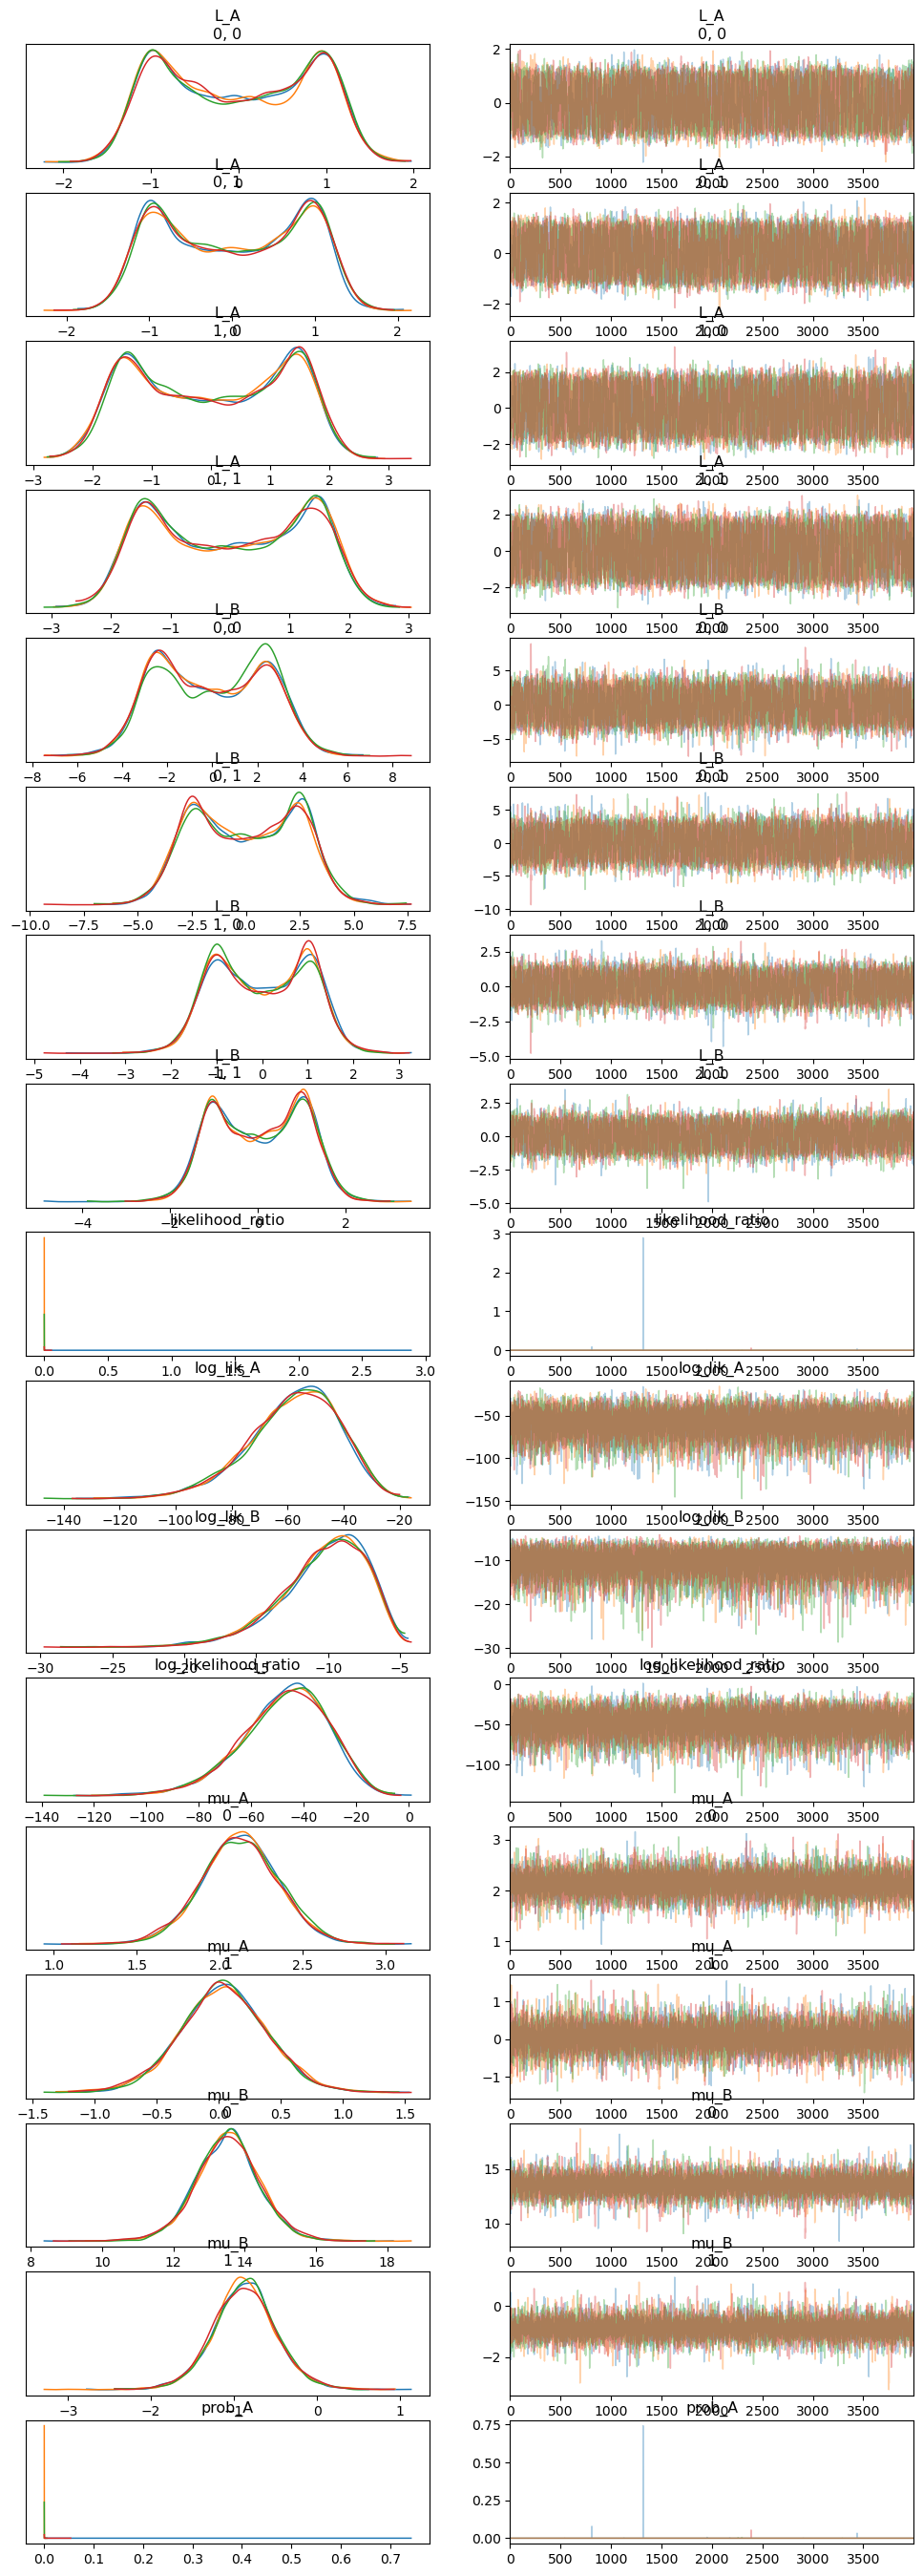

In [7]:
# traceplots
az.plot_trace(fit, compact=False)

In [40]:
draws_df = fit.draws_pd()
draws_df = draws_df[['log_likelihood_ratio', 'likelihood_ratio', 'prob_A']]
draws_df = abs(draws_df) # sign does not matter for ratios in our case, prob_A is always positive
# log likelihood ratio median + hdi
log_likelihood_ratio_median = np.round(draws_df['log_likelihood_ratio'].median(), 4)
log_likelihood_ratio_hdi = np.round(az.hdi(draws_df['log_likelihood_ratio'].values, hdi_prob=0.95), 4)
print(f"log_likelihood_ratio_median: {log_likelihood_ratio_median}, 95% HDI: {log_likelihood_ratio_hdi}")

# likelihood ratio median + hdi
likelihood_ratio_median = np.round(draws_df['likelihood_ratio'].median(), 4)
likelihood_ratio_hdi = np.round(az.hdi(draws_df['likelihood_ratio'].values, hdi_prob=0.95), 4)
print(f"likelihood_ratio_median: {likelihood_ratio_median}, 95% HDI: {likelihood_ratio_hdi}")

prob_A, prob_A_mcse = np.round(draws_df['prob_A'].mean(), 4), np.round(az.mcse(draws_df['prob_A'].values), 4)
print(f"prob_A: {prob_A} +- {prob_A_mcse}")

log_likelihood_ratio_median: 45.9469, 95% HDI: [16.4353 79.9632]
likelihood_ratio_median: 0.0, 95% HDI: [0. 0.]
prob_A: 0.0001 +- 0.0
